# 🎯 Label Noise Injection Ablation Study
## Reputation-Based FL vs Standard FL Under Attack

**Scenario:** Simulating real-world WBAN data quality issues
- Client 1: Clean (0% noise)
- Client 2: Low noise (10% label flips)
- Client 3: Medium noise (30% label flips)
- Client 4: High noise/Malicious (50% label flips)
- Client 5: Clean (0% noise)

**Comparison:**
- ❌ Baseline: Standard FedAvg (no reputation filtering)
- ✅ Proposed: Reputation-weighted FedAvg (with filtering)

In [1]:
# ===================================================================
# COMPLETE LABEL NOISE ABLATION STUDY - SINGLE CELL EXECUTION
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, log_loss
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# ===================================================================
# 1. DATA LOADING AND PREPROCESSING
# ===================================================================
print("="*70)
print("STEP 1: LOADING SECURECARE WBAN DATASET")
print("="*70)

# Load dataset
df = pd.read_csv("SecureCare_Data.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])
print(f"✓ Dataset loaded: {df.shape}")
print(f"✓ Classes: {le.classes_}")
print(f"✓ Class distribution:\n{df['Class'].value_counts().sort_index()}\n")

# ===================================================================
# 2. FEATURE EXTRACTION (WINDOW-BASED)
# ===================================================================
print("="*70)
print("STEP 2: EXTRACTING WINDOWED FEATURES")
print("="*70)

WINDOW_SIZE = 128
STEP_SIZE = 64

def extract_features(df, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    feats, labels = [], []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        label = window['Class'].mode()[0]
        
        ax, ay, az = window['Acc_x'], window['Acc_y'], window['Acc_z']
        amag = np.sqrt(ax**2 + ay**2 + az**2)
        
        feature_dict = {
            'Acc_x_mean': ax.mean(), 'Acc_y_mean': ay.mean(), 'Acc_z_mean': az.mean(),
            'Acc_x_std': ax.std(), 'Acc_y_std': ay.std(), 'Acc_z_std': az.std(),
            'Acc_x_min': ax.min(), 'Acc_y_min': ay.min(), 'Acc_z_min': az.min(),
            'Acc_x_max': ax.max(), 'Acc_y_max': ay.max(), 'Acc_z_max': az.max(),
            'Acc_mag_mean': amag.mean(), 'Acc_mag_std': amag.std(),
            'Acc_range': (pd.DataFrame({'x':ax,'y':ay,'z':az}).max().mean() - 
                         pd.DataFrame({'x':ax,'y':ay,'z':az}).min().mean()),
            'Acc_energy': (ax**2 + ay**2 + az**2).sum()
        }
        feats.append(feature_dict)
        labels.append(label)
    
    features_df = pd.DataFrame(feats)
    features_df['Class'] = labels
    return features_df

df_feat = extract_features(df)
print(f"✓ Features extracted: {df_feat.shape}\n")

# ===================================================================
# 3. TRAIN/TEST SPLIT AND NORMALIZATION
# ===================================================================
print("="*70)
print("STEP 3: SPLITTING AND NORMALIZING DATA")
print("="*70)

X = df_feat.drop('Class', axis=1)
y = df_feat['Class']

scaler = MinMaxScaler()
Xn = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    Xn, y, test_size=0.2, random_state=42, stratify=y
)

n_classes = len(np.unique(y_train))
print(f"✓ Train samples: {len(X_train)}")
print(f"✓ Test samples: {len(X_test)}")
print(f"✓ Number of classes: {n_classes}\n")

# ===================================================================
# 4. LABEL NOISE INJECTION FUNCTION
# ===================================================================
print("="*70)
print("STEP 4: DEFINING LABEL NOISE INJECTION")
print("="*70)

def inject_label_noise(y, noise_rate=0.3, n_classes=5, seed=42):
    """
    Inject label noise by randomly flipping labels.
    
    Args:
        y: Original labels
        noise_rate: Fraction of labels to flip (0.0 to 1.0)
        n_classes: Total number of classes
        seed: Random seed for reproducibility
    
    Returns:
        y_noisy: Labels with noise injected
    """
    np.random.seed(seed)
    y_noisy = y.copy()
    n_flip = int(len(y) * noise_rate)
    
    if n_flip == 0:
        return y_noisy
    
    flip_idx = np.random.choice(len(y), n_flip, replace=False)
    
    for idx in flip_idx:
        original_label = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]
        # Generate wrong class labels
        wrong_classes = [c for c in range(n_classes) if c != original_label]
        new_label = np.random.choice(wrong_classes)
        
        if hasattr(y_noisy, 'iloc'):
            y_noisy.iloc[idx] = new_label
        else:
            y_noisy[idx] = new_label
    
    return y_noisy

print("✓ Label noise injection function defined\n")

# ===================================================================
# 5. CREATE CLIENTS WITH NOISE
# ===================================================================
print("="*70)
print("STEP 5: CREATING FEDERATED CLIENTS WITH VARYING NOISE LEVELS")
print("="*70)

# Noise configuration
NOISE_CONFIG = {
    1: 0.0,   # Clean
    2: 0.1,   # 10% noise
    3: 0.3,   # 30% noise
    4: 0.5,   # 50% noise (malicious)
    5: 0.7    # Byzantine adversary
}

def make_clients_with_noise(X, y, noise_config, num_clients=5, seed=42):
    """
    Create stratified federated clients with label noise injection.
    """
    skf = StratifiedKFold(n_splits=num_clients, shuffle=True, random_state=seed)
    clients = []
    
    for client_id, (_, idx) in enumerate(skf.split(X, y), start=1):
        Xc = X[idx]
        yc = y.iloc[idx].reset_index(drop=True)
        
        # Inject noise based on configuration
        noise_rate = noise_config.get(client_id, 0.0)
        yc_noisy = inject_label_noise(yc, noise_rate, n_classes, seed=seed+client_id)
        
        clients.append({
            'id': client_id,
            'X': Xc,
            'y': yc_noisy,
            'y_clean': yc,  # Keep clean labels for analysis
            'noise_rate': noise_rate
        })
        
        # Calculate actual noise
        actual_noise = np.mean(yc_noisy != yc)
        print(f"Client {client_id}: {len(yc)} samples | "
              f"Target noise: {noise_rate*100:.0f}% | "
              f"Actual noise: {actual_noise*100:.1f}%")
    
    return clients

clients_noisy = make_clients_with_noise(X_train, y_train, NOISE_CONFIG)
print()

# ===================================================================
# 6. MODEL BUILDING FUNCTION
# ===================================================================
print("="*70)
print("STEP 6: DEFINING MODEL ARCHITECTURE")
print("="*70)

def build_model():
    """Build ensemble model (XGBoost + RandomForest)"""
    xgb = XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        eval_metric='mlogloss', random_state=42
    )
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42
    )
    voter = VotingClassifier(
        estimators=[('xgb', xgb), ('rf', rf)],
        voting='soft'
    )
    return voter

print("✓ Model architecture: XGBoost + RandomForest ensemble (soft voting)\n")

# ===================================================================
# 7. REPUTATION CALCULATION
# ===================================================================
def calculate_reputation_score(y_true, y_pred_proba):
    """
    Calculate reputation based on log loss.
    Returns score in range [0, 1] where higher is better.
    """
    try:
        loss = log_loss(y_true, y_pred_proba)
        score = np.exp(-loss)  # Convert to 0-1 scale
        return min(score, 1.0)
    except:
        y_pred = np.argmax(y_pred_proba, axis=1)
        return accuracy_score(y_true, y_pred)

# ===================================================================
# 8. FEDERATED LEARNING FUNCTION
# ===================================================================
print("="*70)
print("STEP 7: DEFINING FEDERATED LEARNING FUNCTION")
print("="*70)

def federated_learning(clients, X_test, y_test, rounds=30, 
                      use_reputation=True, reputation_threshold=0.3):
    
    num_clients = len(clients)
    
    # Storage for results
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'reputations': {i: [] for i in range(1, num_clients+1)},
        'weights': {i: [] for i in range(1, num_clients+1)},
        'participation': {i: [] for i in range(1, num_clients+1)},
        'client_metrics': [],
        'convergence_round': None
    }
    
    # Initialize reputations
    reputations = {i: 1.0 for i in range(1, num_clients+1)}
    
    print(f"\n{'='*70}")
    print(f"TRAINING: {'WITH REPUTATION' if use_reputation else 'WITHOUT REPUTATION (BASELINE)'}")
    print(f"{'='*70}\n")
    
    for r in range(1, rounds+1):
        print(f"Round {r}/{rounds}...", end=' ')
        
        # Client local training
        client_probas = []
        client_data_sizes = []
        round_reputations = []
        round_metrics = []
        active_clients = []
        
        for client in clients:
            cid = client['id']
            
            # Check reputation threshold
            if use_reputation and reputations[cid] < reputation_threshold:
                # Client filtered out
                results['participation'][cid].append(0)
                results['weights'][cid].append(0.0)
                continue
            
            # Split client data for training and local validation
            Xc, yc = client['X'], client['y']
            split_idx = int(len(Xc) * 0.8)
            Xc_train, Xc_val = Xc[:split_idx], Xc[split_idx:]
            yc_train, yc_val = yc[:split_idx], yc[split_idx:]
            
            # Train local model
            model = build_model()
            model.fit(Xc_train, yc_train)
            
            # Get predictions on test set
            proba = model.predict_proba(X_test)
            client_probas.append(proba)
            client_data_sizes.append(len(Xc_train))
            active_clients.append(cid)
            
            # Calculate reputation based on local validation
            val_proba = model.predict_proba(Xc_val)
            reputation_score = calculate_reputation_score(yc_val, val_proba)
            reputations[cid] = reputation_score
            round_reputations.append(reputation_score)
            
            # Store reputation
            results['reputations'][cid].append(reputation_score)
            results['participation'][cid].append(1)
            
            # Calculate client metrics
            y_pred = np.argmax(proba, axis=1)
            client_acc = accuracy_score(y_test, y_pred)
            round_metrics.append({
                'client_id': cid,
                'round': r,
                'accuracy': client_acc,
                'reputation': reputation_score,
                'noise_rate': client['noise_rate']
            })
        
        # Aggregate predictions
        if len(client_probas) == 0:
            print("No active clients!")
            break
        
        # Calculate aggregation weights
        if use_reputation:
            # Reputation-weighted aggregation
            weights = np.array(round_reputations)
            weights = weights / weights.sum()
        else:
            # Standard FedAvg (data-size weighted)
            weights = np.array(client_data_sizes, dtype=float)
            weights = weights / weights.sum()
        
        # Store weights
        for i, cid in enumerate(active_clients):
            results['weights'][cid].append(weights[i])
        
        # Aggregate
        P_global = np.zeros_like(client_probas[0])
        for i, proba in enumerate(client_probas):
            P_global += weights[i] * proba
        
        # Evaluate global model
        y_pred_global = np.argmax(P_global, axis=1)
        acc = accuracy_score(y_test, y_pred_global)
        prec = precision_score(y_test, y_pred_global, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred_global, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_global, average='weighted', zero_division=0)
        
        results['accuracy'].append(acc)
        results['precision'].append(prec)
        results['recall'].append(rec)
        results['f1'].append(f1)
        results['client_metrics'].extend(round_metrics)
        
        # Check convergence (reaching 60% accuracy)
        if results['convergence_round'] is None and acc >= 0.60:
            results['convergence_round'] = r
        
        print(f"Acc={acc:.4f}, Active={len(active_clients)}/{num_clients}")
    
    # Fill missing reputation values for filtered clients
    for cid in range(1, num_clients+1):
        if len(results['reputations'][cid]) < rounds:
            # Pad with last known reputation or 0
            last_rep = results['reputations'][cid][-1] if results['reputations'][cid] else 0.0
            while len(results['reputations'][cid]) < rounds:
                results['reputations'][cid].append(last_rep)
        if len(results['weights'][cid]) < rounds:
            while len(results['weights'][cid]) < rounds:
                results['weights'][cid].append(0.0)
    
    # Final confusion matrix
    results['confusion_matrix'] = confusion_matrix(y_test, y_pred_global)
    
    return results

print("✓ Federated learning function defined\n")

# ===================================================================
# 9. RUN EXPERIMENTS
# ===================================================================
print("="*70)
print("STEP 8: RUNNING ABLATION EXPERIMENTS")
print("="*70)

ROUNDS = 30

# Experiment 1: Standard FedAvg (no reputation)
results_baseline = federated_learning(
    clients_noisy, X_test, y_test, 
    rounds=ROUNDS, use_reputation=False
)

# Experiment 2: Reputation-based FedAvg
results_reputation = federated_learning(
    clients_noisy, X_test, y_test, 
    rounds=ROUNDS, use_reputation=True, reputation_threshold=0.3
)

print("\n" + "="*70)
print("EXPERIMENTS COMPLETED")
print("="*70)
print(f"\nBaseline (No Reputation):")
print(f"  Final Accuracy: {results_baseline['accuracy'][-1]:.4f}")
print(f"  Convergence Round (60%): {results_baseline['convergence_round']}")
print(f"\nProposed (With Reputation):")
print(f"  Final Accuracy: {results_reputation['accuracy'][-1]:.4f}")
print(f"  Convergence Round (60%): {results_reputation['convergence_round']}")
print(f"\nAccuracy Improvement: {(results_reputation['accuracy'][-1] - results_baseline['accuracy'][-1])*100:+.2f}%")

# ===================================================================
# 10. CALCULATE STATISTICS
# ===================================================================
print("\n" + "="*70)
print("CALCULATING CORRELATION STATISTICS")
print("="*70)

# Correlation: Noise Rate vs Final Reputation
noise_levels = [NOISE_CONFIG[i] for i in range(1, 6)]
final_reputations = [results_reputation['reputations'][i][-1] for i in range(1, 6)]

pearson_corr, pearson_p = pearsonr(noise_levels, final_reputations)
spearman_corr, spearman_p = spearmanr(noise_levels, final_reputations)

print(f"\nNoise Level vs Final Reputation:")
print(f"  Pearson Correlation: {pearson_corr:.4f} (p={pearson_p:.4f})")
print(f"  Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")

# Detection time for malicious client (Client 4)
client4_reps = results_reputation['reputations'][4]
detection_round = next((i+1 for i, rep in enumerate(client4_reps) if rep < 0.5), None)
print(f"\nMalicious Client Detection:")
print(f"  Client 4 (50% noise) detected at round: {detection_round if detection_round else 'Not detected'}")
print(f"  Final reputation: {client4_reps[-1]:.4f}")

# ===================================================================
# 11. COMPREHENSIVE VISUALIZATIONS (11 FIGURES)
# ===================================================================
print("\n" + "="*70)
print("GENERATING 11 COMPREHENSIVE VISUALIZATIONS")
print("="*70 + "\n")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

rounds_axis = np.arange(1, ROUNDS+1)





STEP 1: LOADING SECURECARE WBAN DATASET
✓ Dataset loaded: (72094, 4)
✓ Classes: ['Sitting' 'Speak and Walk' 'Speaking' 'Staying' 'Walking']
✓ Class distribution:
Class
0     9560
1    18673
2    12867
3    16453
4    14541
Name: count, dtype: int64

STEP 2: EXTRACTING WINDOWED FEATURES
✓ Features extracted: (1125, 17)

STEP 3: SPLITTING AND NORMALIZING DATA
✓ Train samples: 900
✓ Test samples: 225
✓ Number of classes: 5

STEP 4: DEFINING LABEL NOISE INJECTION
✓ Label noise injection function defined

STEP 5: CREATING FEDERATED CLIENTS WITH VARYING NOISE LEVELS
Client 1: 180 samples | Target noise: 0% | Actual noise: 0.0%
Client 2: 180 samples | Target noise: 10% | Actual noise: 10.0%
Client 3: 180 samples | Target noise: 30% | Actual noise: 30.0%
Client 4: 180 samples | Target noise: 50% | Actual noise: 50.0%
Client 5: 180 samples | Target noise: 70% | Actual noise: 69.4%

STEP 6: DEFINING MODEL ARCHITECTURE
✓ Model architecture: XGBoost + RandomForest ensemble (soft voting)

STEP 7: D

Generating Figure 2: Client Reputation Evolution (High-Res)...
  ✓ Saved: fig2_reputation_evolution.png (600 DPI)
  ✓ Saved: fig2_reputation_evolution.pdf (Vector)


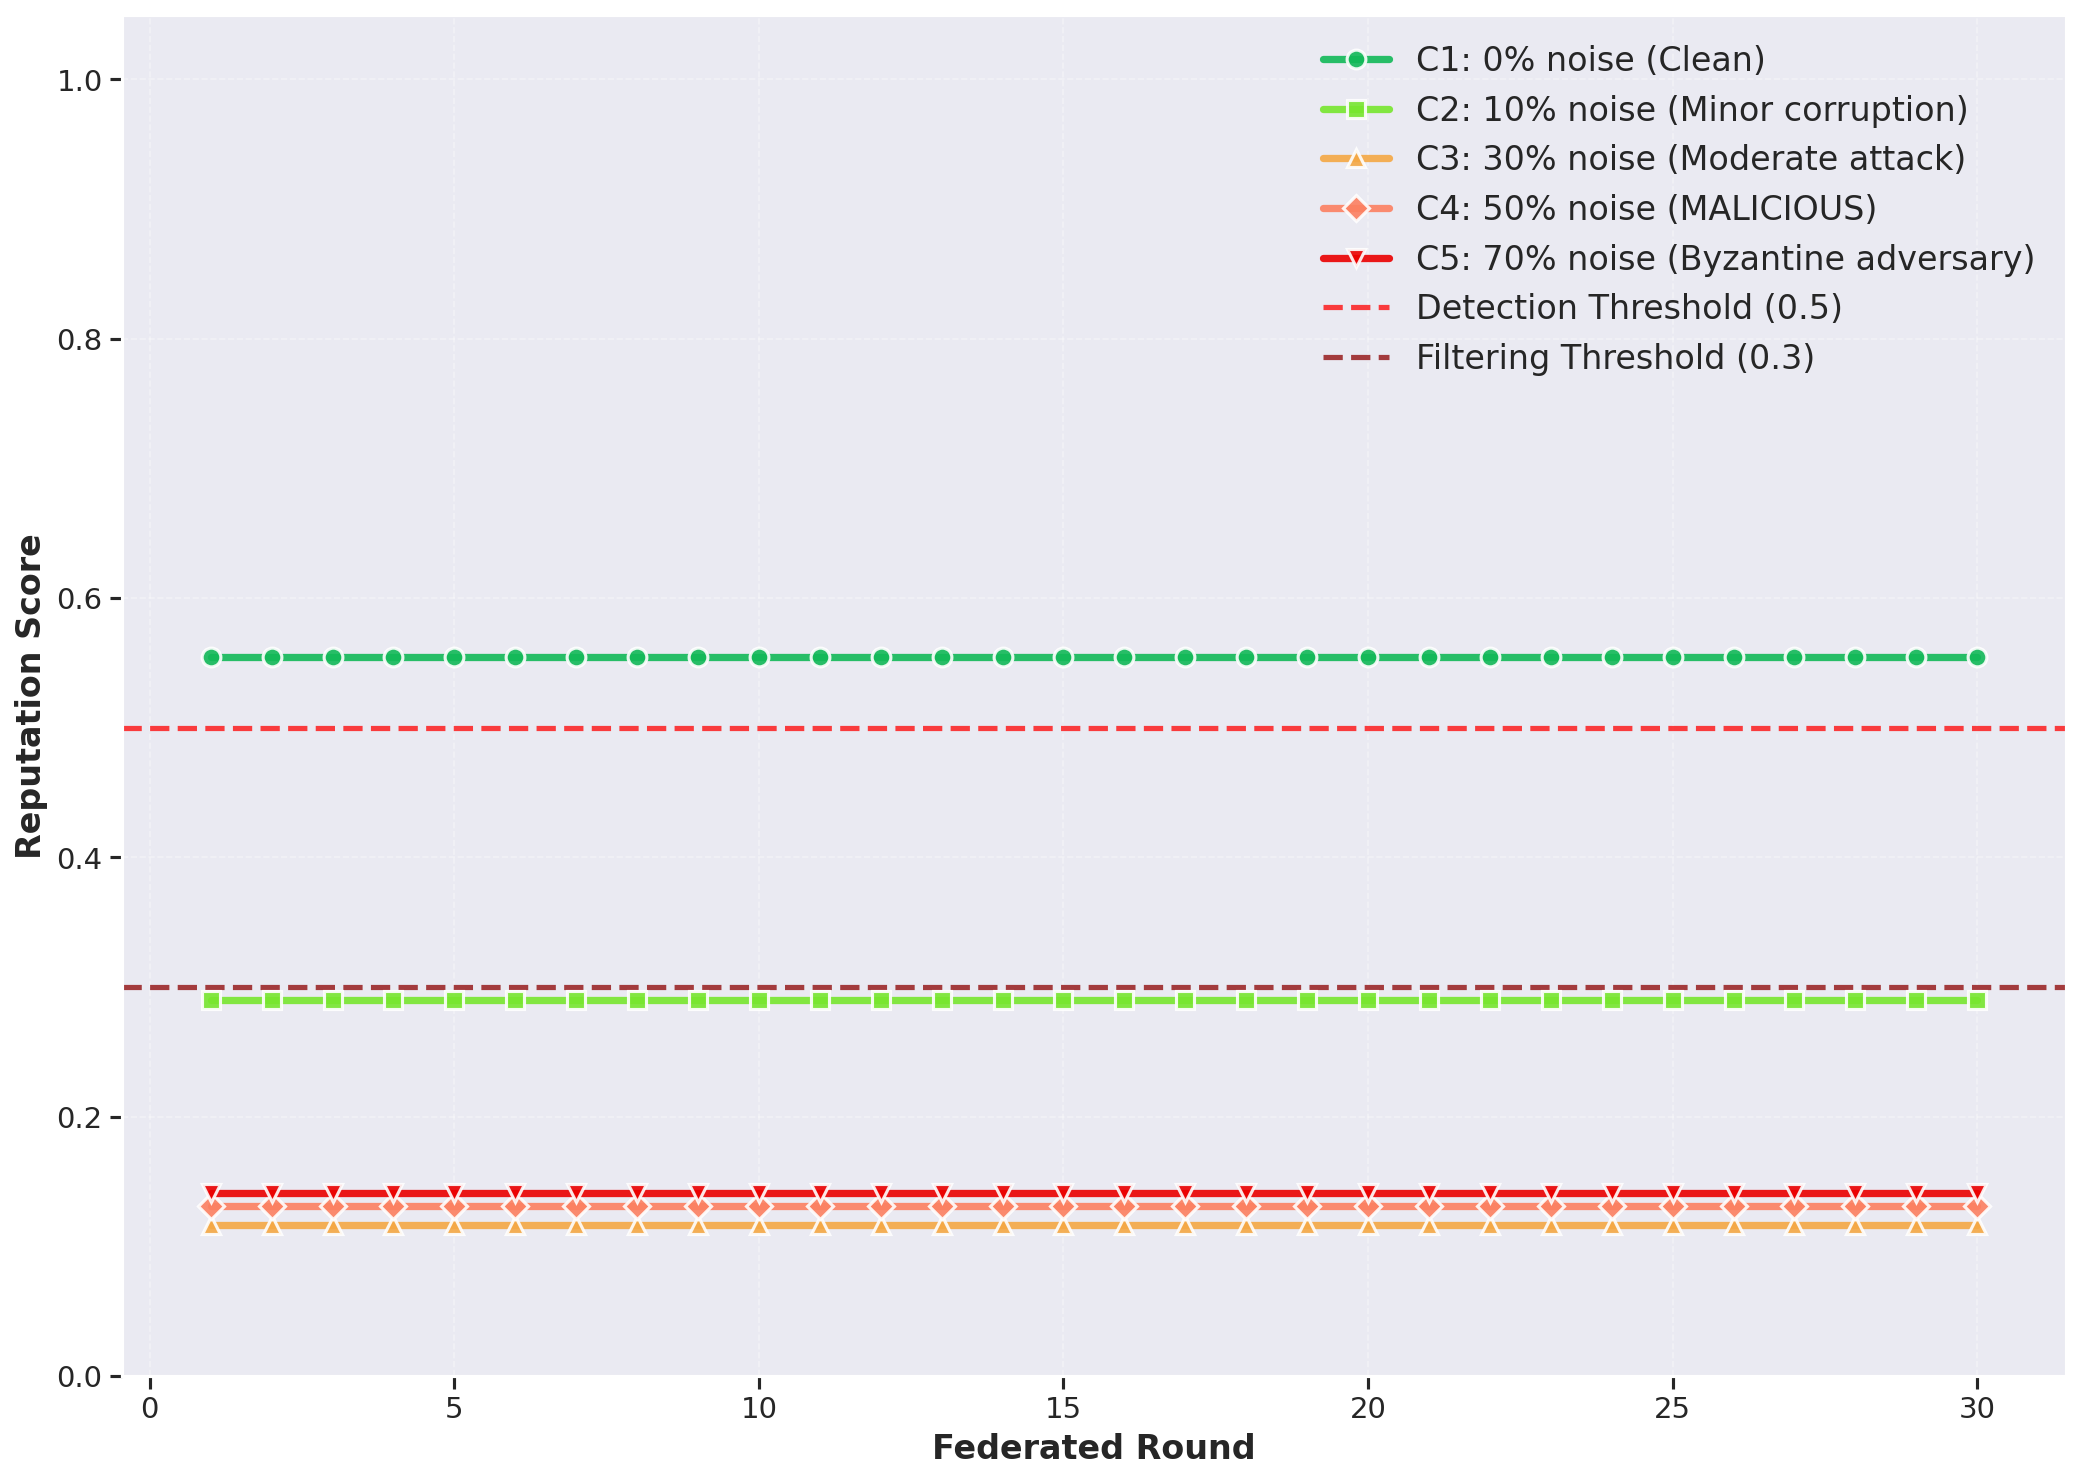

Generating Figure 3: Noise Level vs Final Reputation (High-Res)...
  ✓ Saved: fig3_noise_reputation_correlation.png (600 DPI)
  ✓ Saved: fig3_noise_reputation_correlation.pdf (Vector)


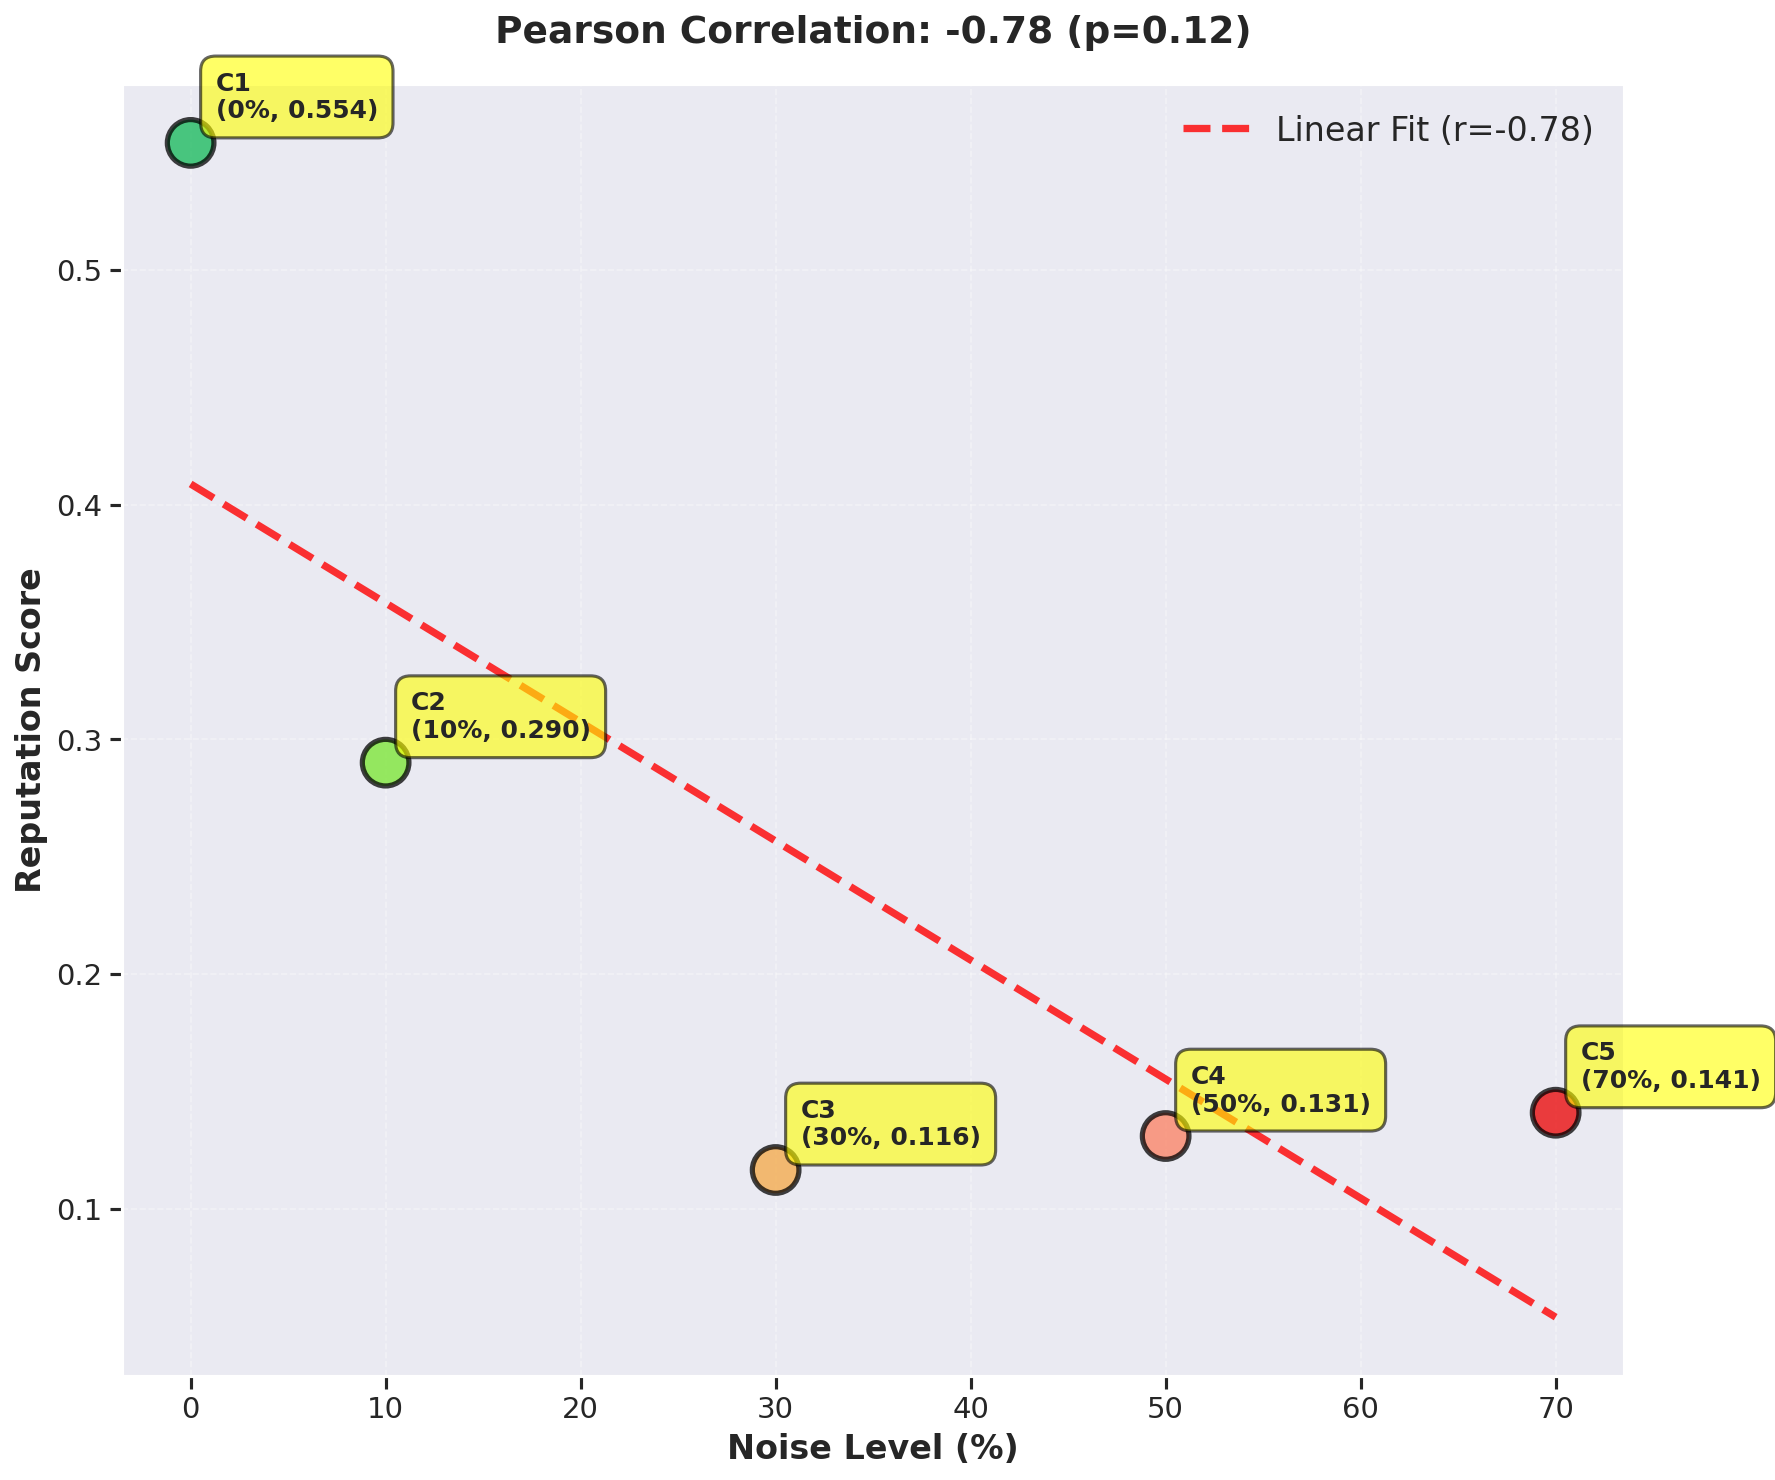

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generating Figure 8: Client Participation Analysis (High-Res)...
  ✓ Saved: fig8_client_participation.png (600 DPI)
  ✓ Saved: fig8_client_participation.pdf (Vector)


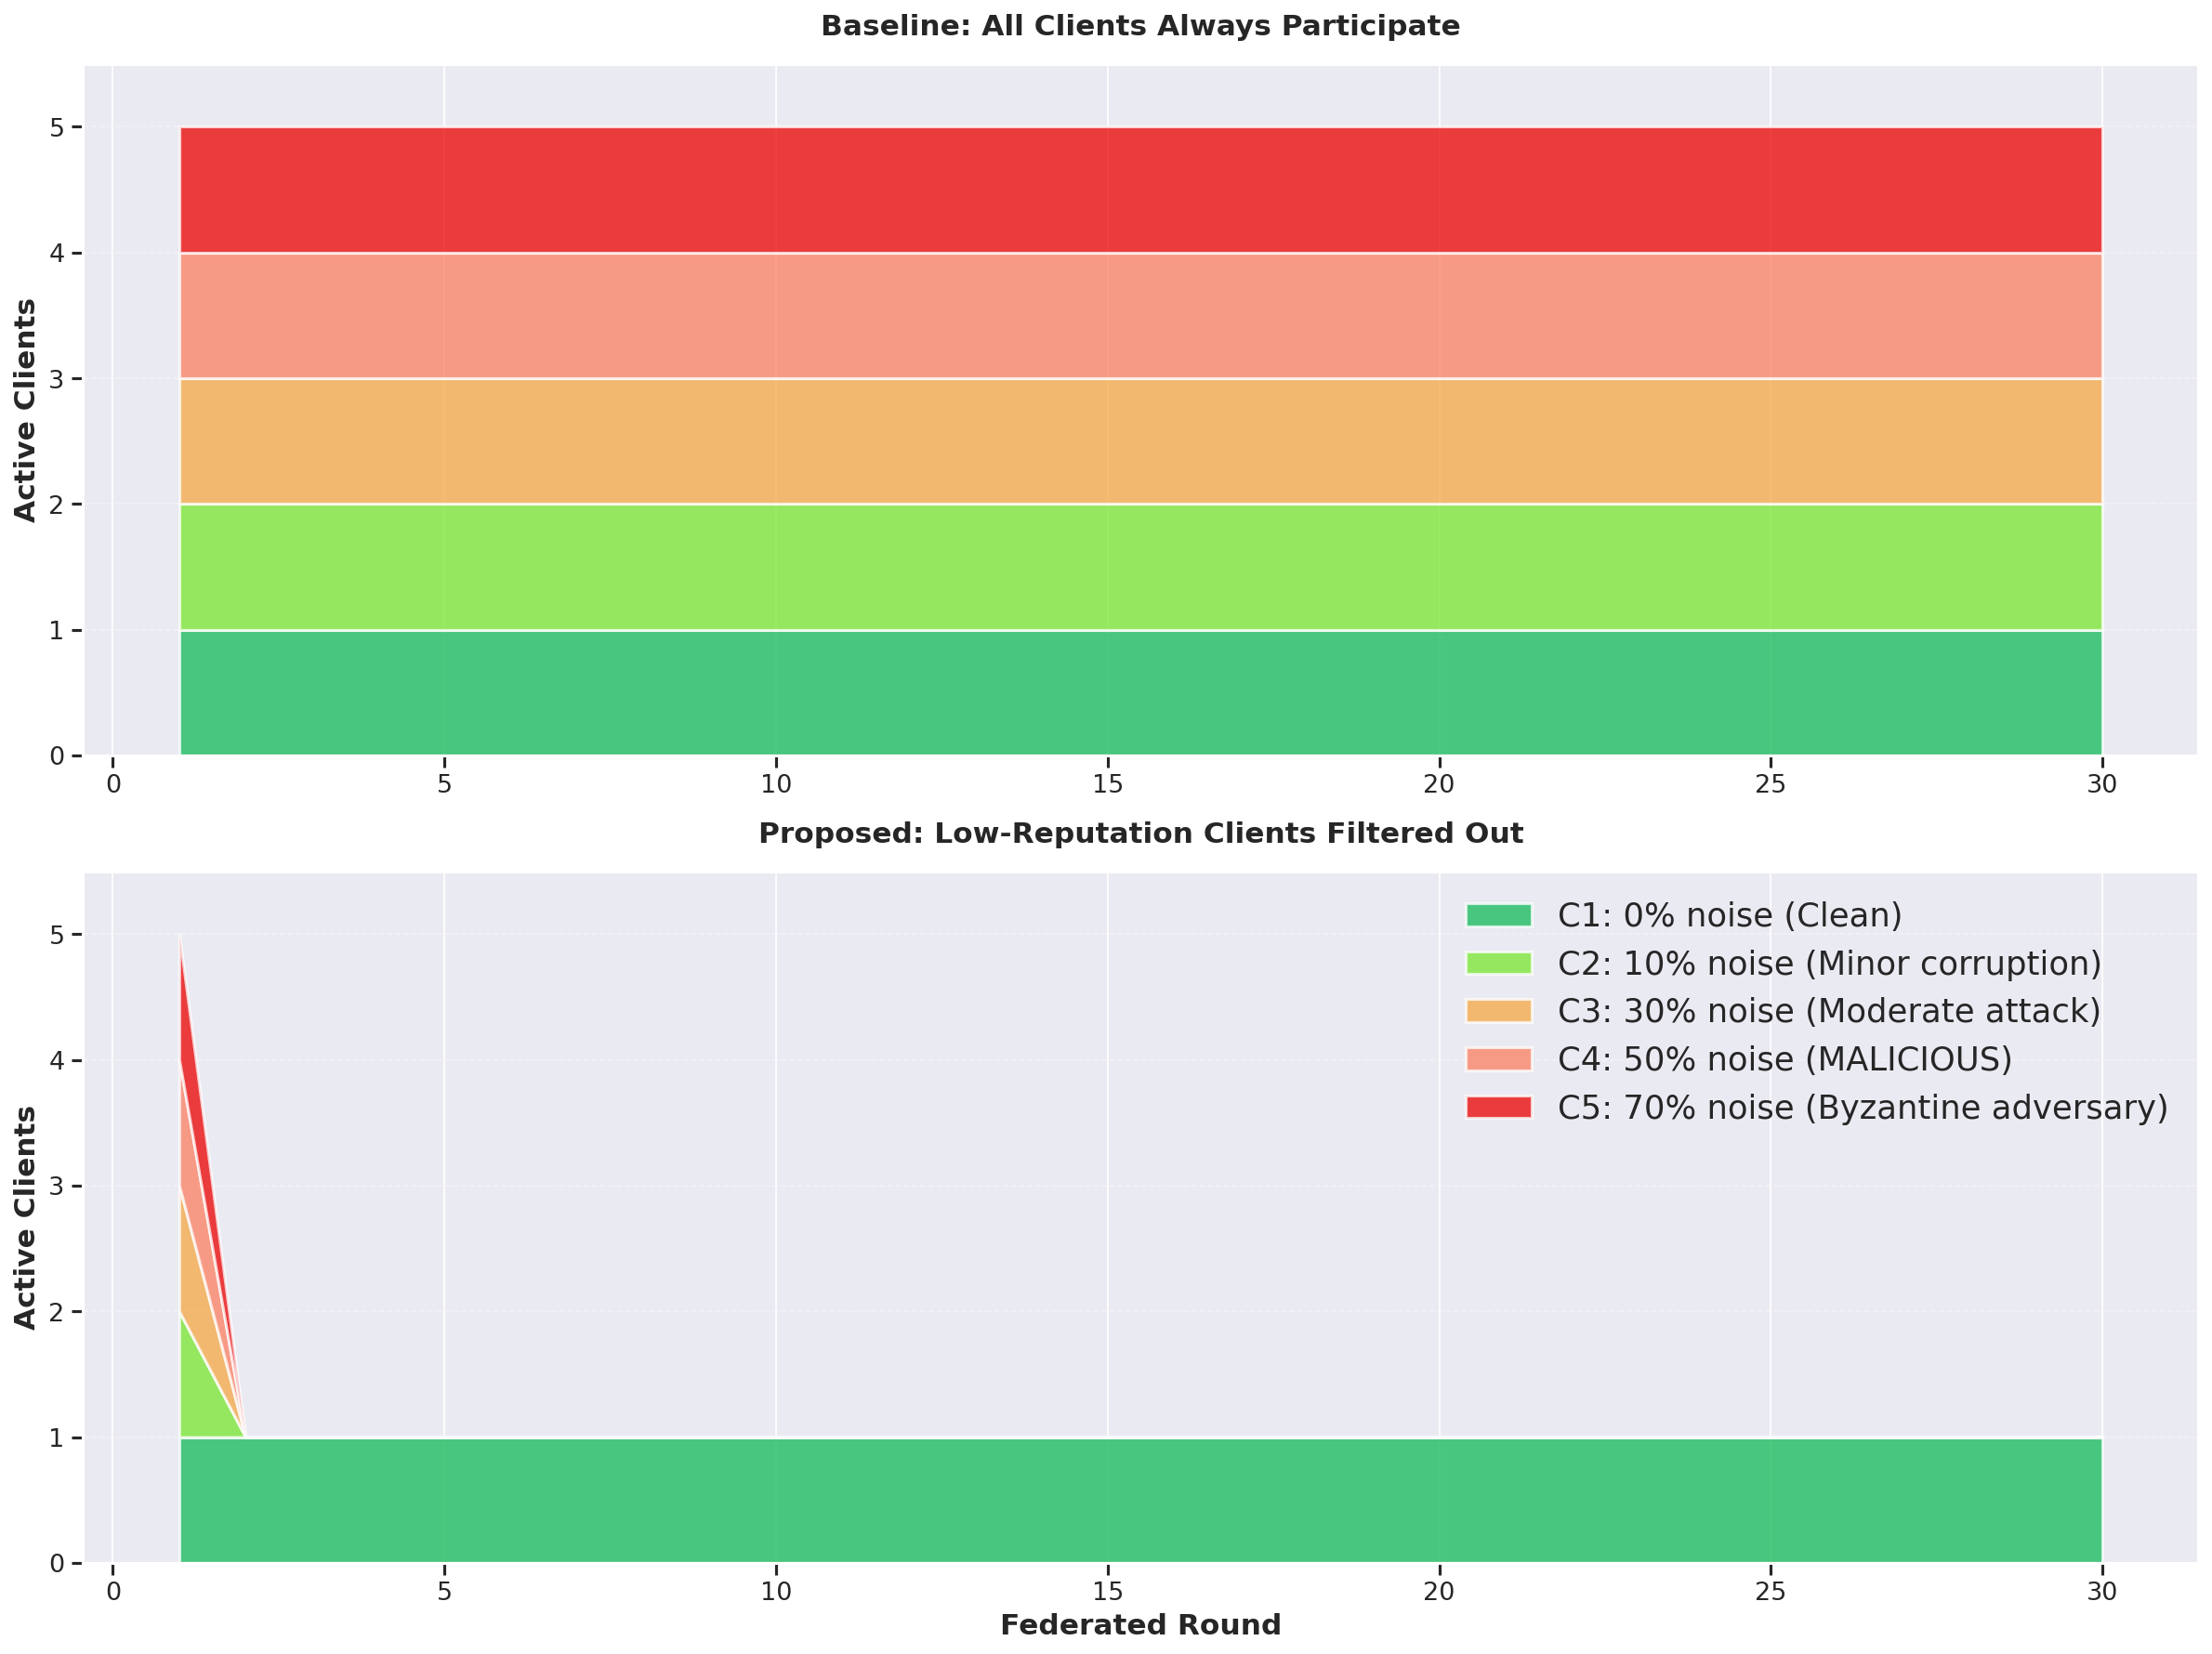


ALL HIGH-RESOLUTION FIGURES GENERATED SUCCESSFULLY!

Generated files:
  • fig2_reputation_evolution.png (600 DPI)
  • fig2_reputation_evolution.pdf (Vector)
  • fig3_noise_reputation_correlation.png (600 DPI)
  • fig3_noise_reputation_correlation.pdf (Vector)
  • fig8_client_participation.png (600 DPI)
  • fig8_client_participation.pdf (Vector)

Recommendation: Use PDF files for LaTeX papers (infinite resolution)
                Use PNG files for PowerPoint/Word (600 DPI is publication-quality)


In [3]:
# ===================================================================
# HIGH-RESOLUTION FIGURE GENERATION
# Optimized for publication-quality output
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np

# Set global matplotlib parameters for high-quality output
plt.rcParams['figure.dpi'] = 150  # Display resolution
plt.rcParams['savefig.dpi'] = 600  # Save resolution (publication quality)
plt.rcParams['font.family'] = 'DejaVu Sans'  # Professional font
plt.rcParams['font.size'] = 11  # Base font size
plt.rcParams['axes.linewidth'] = 1.5  # Thicker axes
plt.rcParams['grid.linewidth'] = 0.8  # Grid line width
plt.rcParams['lines.linewidth'] = 2.5  # Line plot width

# ===================================================================
# FIGURE 2: Client Reputation Evolution
# ===================================================================
print("Generating Figure 2: Client Reputation Evolution (High-Res)...")
fig2, ax = plt.subplots(1, 1, figsize=(14, 10))  # Larger figure size

colors = ["#12b958", "#77e62e", "#f5a844", "#fc8061", "#eb0000"]
markers = ['o', 's', '^', 'D', 'v']
client_labels = [
    'C1: 0% noise (Clean)',
    'C2: 10% noise (Minor corruption)',
    'C3: 30% noise (Moderate attack)',
    'C4: 50% noise (MALICIOUS)',
    'C5: 70% noise (Byzantine adversary)'
]

for cid in range(1, 6):
    reps = results_reputation['reputations'][cid]
    ax.plot(rounds_axis, reps, marker=markers[cid-1], 
            label=client_labels[cid-1], linewidth=3.5,  # Thicker lines
            markersize=9, color=colors[cid-1], alpha=0.90,  # Larger markers
            markeredgewidth=1.5, markeredgecolor='white')  # White edge for clarity

# Threshold lines
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2.5, 
           label='Detection Threshold (0.5)', alpha=0.75, zorder=1)
ax.axhline(y=0.3, color='darkred', linestyle='--', linewidth=2.5, 
           label='Filtering Threshold (0.3)', alpha=0.75, zorder=1)

# Labels and title with larger fonts
ax.set_xlabel('Federated Round', fontsize=16, fontweight='bold')
ax.set_ylabel('Reputation Score', fontsize=16, fontweight='bold')


# Larger tick labels
ax.tick_params(axis='both', labelsize=14, width=1.5, length=6)

# Enhanced legend
ax.legend(loc='best', fontsize=16, framealpha=0.95, 
          edgecolor='black', fancybox=True, shadow=True)

# Grid
ax.grid(True, alpha=0.35, linestyle='--', linewidth=0.8)
ax.set_ylim([0, 1.05])

# Tight layout and save
plt.tight_layout()
plt.savefig('fig2_reputation_evolution.png', 
            dpi=700,  
            bbox_inches='tight', 
            facecolor='white',  # White background
            edgecolor='none',
            format='png',
            metadata={'Creator': 'Matplotlib', 'Title': 'Client Reputation Evolution'})
print("  ✓ Saved: fig2_reputation_evolution.png (600 DPI)")
plt.savefig('fig2_reputation_evolution.pdf', bbox_inches='tight')  # Also save as PDF
print("  ✓ Saved: fig2_reputation_evolution.pdf (Vector)")
plt.show()
plt.close()

# ===================================================================
# FIGURE 3: Noise vs Reputation Correlation
# ===================================================================
print("Generating Figure 3: Noise Level vs Final Reputation (High-Res)...")
fig3, ax = plt.subplots(1, 1, figsize=(12, 10))  # Larger figure

# Scatter plot with larger points
ax.scatter(np.array(noise_levels)*100, final_reputations, 
           s=500, c=colors, alpha=0.75, edgecolors='black', linewidth=2.5, zorder=3)

# Add labels for each point with larger font
for i, (noise, rep) in enumerate(zip(noise_levels, final_reputations)):
    ax.annotate(f'C{i+1}\n({noise*100:.0f}%, {rep:.3f})', 
                xy=(noise*100, rep), xytext=(12, 12),
                textcoords='offset points', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.6', fc='yellow', alpha=0.6, 
                         edgecolor='black', linewidth=1.5),
                zorder=4)

# Fit line
z = np.polyfit(np.array(noise_levels)*100, final_reputations, 1)
p = np.poly1d(z)
ax.plot(np.array(noise_levels)*100, p(np.array(noise_levels)*100), 
        "r--", linewidth=3.5, label=f'Linear Fit (r={pearson_corr:.2f})', 
        alpha=0.8, zorder=2)

# Labels and title
ax.set_xlabel('Noise Level (%)', fontsize=16, fontweight='bold')
ax.set_ylabel('Reputation Score', fontsize=16, fontweight='bold')
ax.set_title(f'Pearson Correlation: {pearson_corr:.2f} (p={pearson_p:.2f})', 
             fontsize=18, fontweight='bold', pad=20)

# Tick labels
ax.tick_params(axis='both', labelsize=14, width=1.5, length=6)

# Legend
ax.legend(fontsize=16, framealpha=0.95, edgecolor='black', 
          fancybox=True, shadow=True)

# Grid
ax.grid(True, alpha=0.35, linestyle='--', linewidth=0.8)

# Save high-resolution
plt.tight_layout()
plt.savefig('fig3_noise_reputation_correlation.png', 
            dpi=600, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            format='png')
print("  ✓ Saved: fig3_noise_reputation_correlation.png (600 DPI)")
plt.savefig('fig3_noise_reputation_correlation.pdf', bbox_inches='tight')
print("  ✓ Saved: fig3_noise_reputation_correlation.pdf (Vector)")
plt.show()
plt.close()

# ===================================================================
# FIGURE 8: Client Participation Over Time
# ===================================================================
print("Generating Figure 8: Client Participation Analysis (High-Res)...")
fig8, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))  # Larger figure

# Stacked area chart for baseline
baseline_participation = np.array([results_baseline['participation'][i] 
                                   for i in range(1, 6)])

# Create custom labels for baseline (without noise info)
baseline_labels = [f'Client {i}' for i in range(1, 6)]

ax1.stackplot(rounds_axis, baseline_participation, 
              
              colors=colors, alpha=0.75, edgecolor='white', linewidth=1.5)
ax1.set_ylabel('Active Clients', fontsize=15, fontweight='bold')
ax1.set_title('Baseline: All Clients Always Participate', 
              fontsize=15, fontweight='bold', pad=15)
ax1.tick_params(axis='both', labelsize=13, width=1.5, length=6)
ax1.legend(loc='upper right', fontsize=14, framealpha=0.95, 
           edgecolor='black', fancybox=True, shadow=True)
ax1.grid(True, alpha=0.35, axis='y', linestyle='--', linewidth=0.8)
ax1.set_ylim([0, 5.5])

# Stacked area chart for reputation-based
reputation_participation = np.array([results_reputation['participation'][i] 
                                      for i in range(1, 6)])
ax2.stackplot(rounds_axis, reputation_participation, 
              labels=client_labels,
              colors=colors, alpha=0.75, edgecolor='white', linewidth=1.5)
ax2.set_xlabel('Federated Round', fontsize=15, fontweight='bold')
ax2.set_ylabel('Active Clients', fontsize=15, fontweight='bold')
ax2.set_title('Proposed: Low-Reputation Clients Filtered Out', 
              fontsize=15, fontweight='bold', pad=15)
ax2.tick_params(axis='both', labelsize=13, width=1.5, length=6)
ax2.legend(loc='upper right', fontsize=17, framealpha=0.95, 
           edgecolor='black', fancybox=True, shadow=True)
ax2.grid(True, alpha=0.35, axis='y', linestyle='--', linewidth=0.8)
ax2.set_ylim([0, 5.5])

# Save high-resolution
plt.tight_layout()
plt.savefig('fig8_client_participation.png', 
            dpi=600, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            format='png')
print("  ✓ Saved: fig8_client_participation.png (600 DPI)")
plt.savefig('fig8_client_participation.pdf', bbox_inches='tight')
print("  ✓ Saved: fig8_client_participation.pdf (Vector)")
plt.show()
plt.close()

print("\n" + "="*70)
print("ALL HIGH-RESOLUTION FIGURES GENERATED SUCCESSFULLY!")
print("="*70)
print("\nGenerated files:")
print("  • fig2_reputation_evolution.png (600 DPI)")
print("  • fig2_reputation_evolution.pdf (Vector)")
print("  • fig3_noise_reputation_correlation.png (600 DPI)")
print("  • fig3_noise_reputation_correlation.pdf (Vector)")
print("  • fig8_client_participation.png (600 DPI)")
print("  • fig8_client_participation.pdf (Vector)")
print("\nRecommendation: Use PDF files for LaTeX papers (infinite resolution)")
print("                Use PNG files for PowerPoint/Word (600 DPI is publication-quality)")